## **Aplicação de Random Forest Regression**
Neste notebook será aplicado o modelo Random Forest Regression utilizando as features extraídas dos dados .
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos modelos benchmark **SARIMA**, **ETS** e **Regressão Linear**. 

In [1]:
# confirgurando diretório
import os
os.chdir("..")

import path
path.config()

# importando bibliotecas
import warnings
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from main.features import add_features
from main.features import add_lagged_features
from main.evaluation import Evaluation
from main.plots import plot_metrics
from main.plots import plot_time_series

# configurando notebook
tqdm.pandas()

warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.2f' % x)

%load_ext autoreload
%autoreload 2

EVAL_PATH = 'notebooks/data/evaluation.csv'

## **Leitura dos Dados**
Leitura dos dados de treino e teste exportados no notebook *analise_exploratoria.ipynb*. Para cada série, foram separados os 70% primeiros pontos de dados para treino e o restante, ou seja, os dados mais recentes, para teste.

In [2]:
# leitura dos dados
train_df = pd.read_csv("notebooks/data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("notebooks/data/test_df.csv", parse_dates=['ds'])

In [3]:
features_train_df = (
    train_df.groupby("unique_id")
    .apply(lambda x: add_features(df=x, df_type='train'))
).reset_index(drop=True)


features_test_df = (
    test_df.groupby("unique_id")
    .apply(lambda x: add_features(df=x, df_type='test'))
).reset_index(drop=True)

In [4]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'outlier_min', 'outlier_max'],
      dtype='object')

In [5]:
# inserindo os lags nos dados de treino e teste

kwargs = {
    'features' : ['feriado', 'month_end', 'outlier_min', 'outlier_max'],
    'lags' : [-3, -2, -1, 1, 2, 3]
}

features_train_df = (
    features_train_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

features_test_df = (
    features_test_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

In [6]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'outlier_min', 'outlier_max',
       'feriado_lag-3', 'feriado_lag-2', 'feriado_lag-1', 'feriado_lag1',
       'feriado_lag2', 'feriado_lag3', 'month_end_lag-3', 'month_end_lag-2',
       'month_end_lag-1', 'month_end_lag1', 'month_end_lag2', 'month_end_lag3',
       'outlier_min_lag-3', 'outlier_min_lag-2', 'outlier_min_lag-1',
       'outlier_min_lag1', 'outlier_min_lag2', 'outlier_min_lag3',
       'outlier_max_lag-3', 'outlier_max_lag-2', 'outlier_max_lag-1',
       'outlier_max_lag1', 'outlier_max_lag2', 'outlier_max_lag3'],
      dtype='object')

## **Random Forest Regression**

In [7]:
def random_forest(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo RandomForest.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = features_test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    train['trend'] = train.index
    fcst_df['trend'] = fcst_df.index + train.index.max() + 1
    
    m = RandomForestRegressor(
        n_estimators=1000, 
        max_depth=10, 
        min_samples_split=4, 
        random_state=1001
    )
    
    m.fit(
        X=train.iloc[:,3:], 
        y=train.y
    )
    
    fcst_df['y_pred'] = m.predict(X=fcst_df.iloc[:,3:])

    return fcst_df

In [8]:
# aplicando modelo para cada série
rf_fcst = features_train_df.groupby("unique_id").apply(random_forest).reset_index(drop=True)

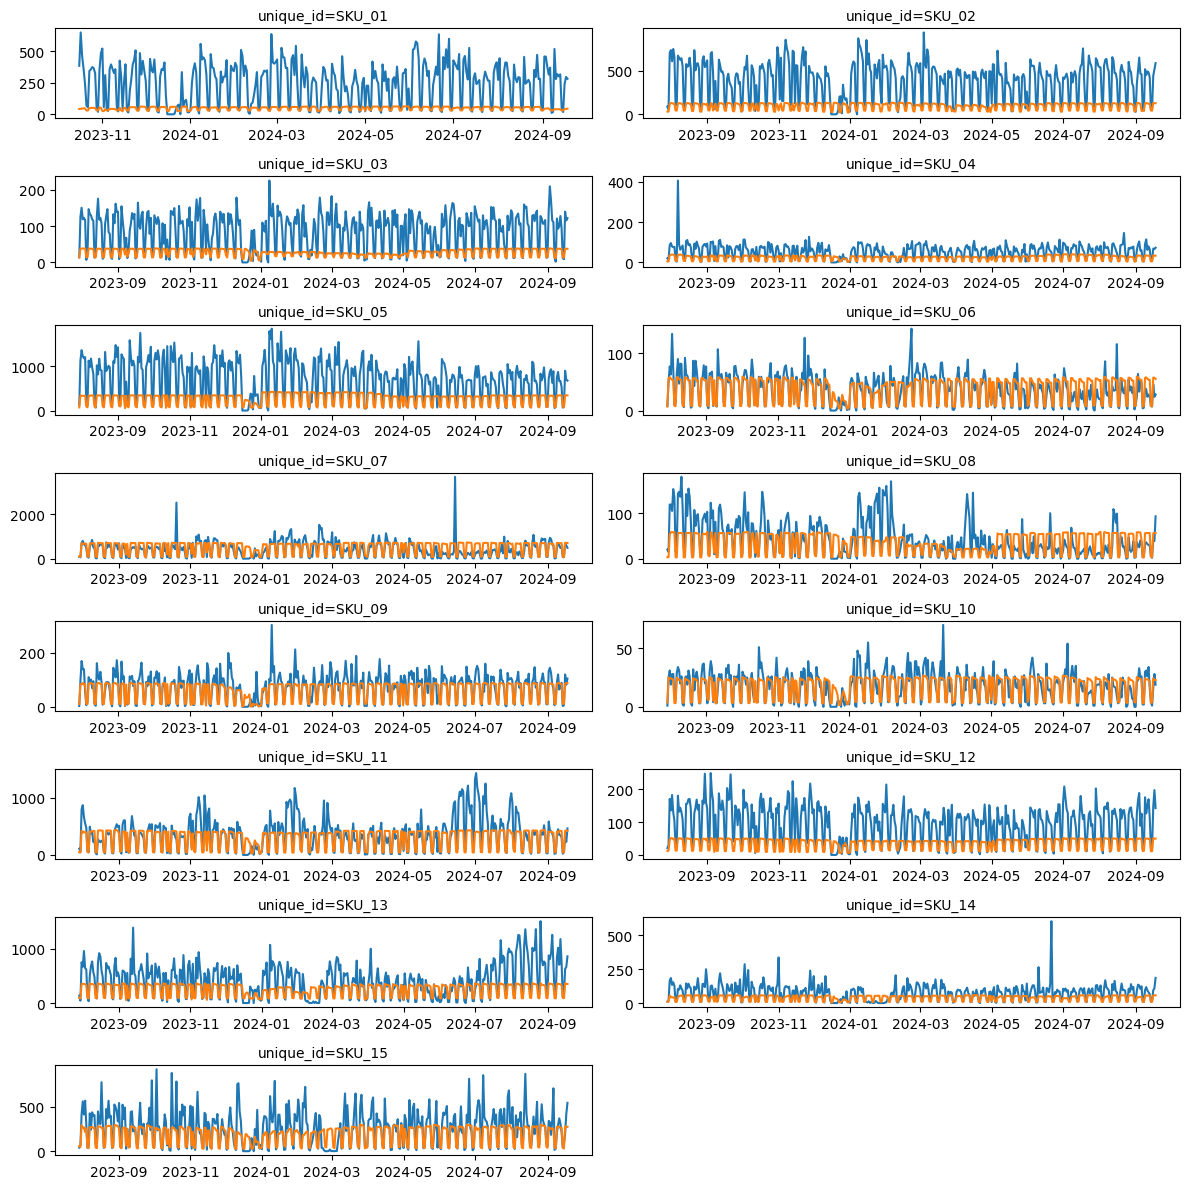

In [9]:
plot_time_series(
    df = rf_fcst,
    data_cols=['y','y_pred'],
    grid=(8, 2),
    figsize=(12, 12)
)

In [10]:
rf_eval = Evaluation(rf_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'Random Forest [+Lags]')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,201.06,63826.43,252.64,-1.26
SKU_02,283.67,117313.39,342.51,-1.24
SKU_03,59.55,5384.14,73.38,-0.91
SKU_04,31.16,1765.57,42.02,-0.22
SKU_05,435.67,306944.02,554.03,-0.44
SKU_06,11.96,294.05,17.15,0.58
SKU_07,197.46,92496.68,304.13,0.35
SKU_08,24.24,1228.20,35.05,0.27
SKU_09,20.85,1043.61,32.30,0.61
SKU_10,5.50,60.12,7.75,0.62


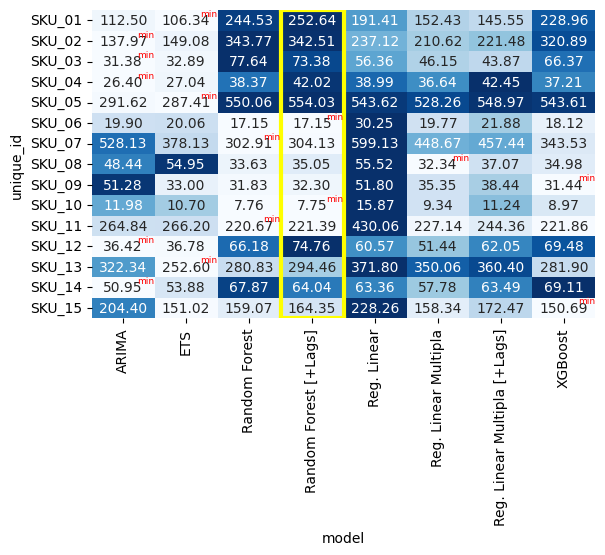

In [13]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)[['unique_id', 'rmse', 'model']].pivot_table('rmse','unique_id','model')
plot_metrics(metrics, hl_col='Random Forest [+Lags]', figsize=(6.5, 4))